In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import seaborn
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [2]:
data = pd.read_csv('rko_films.csv')

In [3]:
X = np.array(data[['Production costs', 'Distribution Cost']].values)
Y = np.array(data[['Total Revenue']].values)

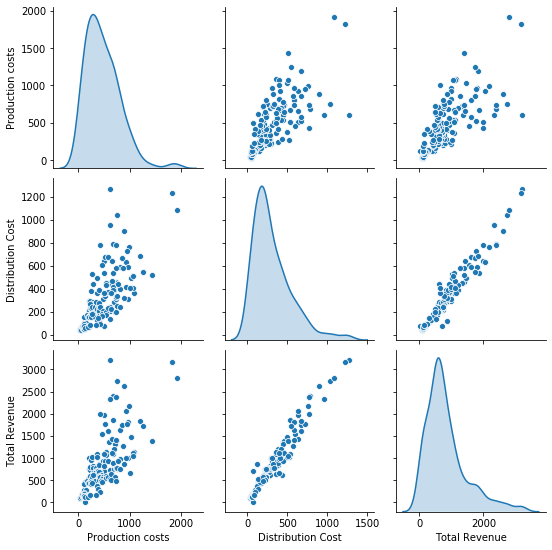

In [4]:
seaborn.pairplot(data[['Production costs', 'Distribution Cost', 'Total Revenue']], diag_kind="kde")

In [5]:
reg = LinearRegression()
reg.fit(X[:,0].reshape(-1,1), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
reg2 = LinearRegression()
reg2.fit(X[:,1].reshape(-1,1), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
k , b = reg.coef_[0][0], reg.intercept_[0]
print('coefs for first feature')
print('coef: ', k)
print('intercept: ',  b)
k , b = reg2.coef_[0][0], reg2.intercept_[0]
print('\ncoefs for second feature')
print('coef: ', k)
print('intercept: ',  b)

coefs for first feature
coef:  1.3929479698371794
intercept:  180.70336195139714

coefs for second feature
coef:  2.582742658882964
intercept:  33.67272036132795


In [8]:
print('r2 for first feature: ', r2_score(reg.predict(X[:,0].reshape(-1,1)), Y))
print('r2 for second feature: ', r2_score(reg.predict(X[:,1].reshape(-1,1)), Y))

r2 for first feature:  0.08142200444299663
r2 for second feature:  -0.3871841805460978


In [9]:
X_with_const = sm.add_constant(X)

In [10]:
w = np.linalg.inv((X_with_const.T).dot(X_with_const)).dot(X_with_const.T).dot(Y)

In [11]:
print(w)

[[16.43111385]
 [ 0.10198592]
 [ 2.48225159]]


In [12]:
print(w[0][0],'+', w[1][0],'*a +', w[2][0], '*b')

16.431113848193807 + 0.10198591904278244 *a + 2.4822515936287886 *b


In [13]:
corrs = data[['Production costs', 'Distribution Cost', 'Total Revenue']].corr()
print(corrs)
corrs = np.array(corrs)

                   Production costs  Distribution Cost  Total Revenue
Production costs           1.000000           0.715859       0.721955
Distribution Cost          0.715859           1.000000       0.972516
Total Revenue              0.721955           0.972516       1.000000


In [14]:
print('r(yx1|x2): ', (corrs[0,2] - corrs[1,2]*corrs[1,0]) / ((1-corrs[1,2]**2)*(1-corrs[1,0]**2))**.5)
print('r(yx2|x1): ', (corrs[1,2] - corrs[0,2]*corrs[1,0]) / ((1-corrs[0,2]**2)*(1-corrs[1,0]**2))**.5)

r(yx1|x2):  0.1585158663234267
r(yx2|x1):  0.9431936980751761


In [15]:
pred = X_with_const.dot(w) 

In [16]:
tail = Y - pred

In [17]:
mape = np.mean(np.abs((tail) / Y)) * 100
print('mape: ', mape,'%')
print('tails std: ', np.std(tail))

mape:  20.6750171905205 %
tails std:  147.92609073914883


In [18]:
print('Tails coef for pair: ', 1 - (1 - r2_score(pred, Y))*(len(Y) - 1)/ (len(Y) - 2))
print('r2 for pair: ', r2_score(pred, Y))
print('r2 for first feature: ', r2_score(reg.predict(X[:,0].reshape(-1,1)), Y))
print('r2 for second feature: ', r2_score(reg.predict(X[:,1].reshape(-1,1)), Y))

Tails coef for pair:  0.9438357517486032
r2 for pair:  0.9442004546593266
r2 for first feature:  0.08142200444299663
r2 for second feature:  -0.3871841805460978


In [20]:
est = sm.OLS(Y.reshape(-1,1), X_with_const)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1362.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           8.95e-98
Time:                        17:42:45   Log-Likelihood:                -994.43
No. Observations:                 155   AIC:                             1995.
Df Residuals:                     152   BIC:                             2004.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4311     21.560      0.762      0.4

In [21]:
est2.get_prediction(X_with_const[0]).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,765.24986,17.519349,730.636989,799.862731,468.10037,1062.39935


(array([ 2.,  0.,  4.,  4.,  1., 14., 26., 48., 31., 11.,  4.,  3.,  3.,
         1.,  3.]),
 array([-516.59363486, -448.50684759, -380.42006031, -312.33327304,
        -244.24648576, -176.15969849, -108.07291121,  -39.98612393,
          28.10066334,   96.18745062,  164.27423789,  232.36102517,
         300.44781245,  368.53459972,  436.621387  ,  504.70817427]),
 <a list of 15 Patch objects>)

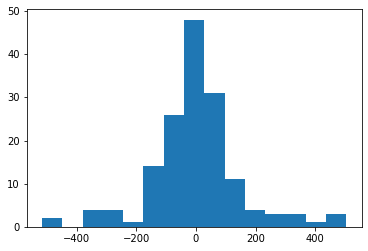

In [22]:
plt.hist(tail, bins = 15)

In [23]:
k2, p = stats.normaltest(tail)
alpha = 1e-3
print(p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

[0.00039348]
The null hypothesis can be rejected
